In [3]:
# Import Library 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso

In [4]:
# Functions Library

# Evaluating function using values from Coefficient array (Setting)
def eval_poly(x, coeffs):
    # coeffs[k] multiplies x^k
    powers = np.vstack([x**k for k in range(len(coeffs))])  # shape (K, N)
    return (coeffs[:, None] * powers).sum(axis=0)

# Formatting + Threshholding Condition
def format_poly(coeffs, var="x", thresh=1e-10):
    terms = []
    for k, c in enumerate(coeffs):
        if abs(c) < thresh:
            continue
        if k == 0:
            terms.append(f"{c:+.5g}")
        elif k == 1:
            terms.append(f"{c:+.5g}·{var}")
        else:
            terms.append(f"{c:+.5g}·{var}^{k}")
    return " ".join(terms) if terms else "0"

def compute_aic_bic(y_true, y_pred, num_params):
    n = len(y_true)
    rss = np.sum((y_true - y_pred)**2)
    aic = 2*num_params + n*np.log(rss/n)
    bic = num_params*np.log(n) + n*np.log(rss/n)
    return aic, bic
    

In [5]:
# Setting for the model

N = 200                    # number of samples
X_MIN, X_MAX = -1.0, 1.0   # sampling range for x
DEGREE = 10                # full polynomial library up to power DEGREE
NOISE_FRAC = 0.05          # noise level as fraction of std(y_true)
TRUE_COEFFS = np.array([3.0, 0.0, -3.0, 0.0, 0.0, 1.0]) # tested model

In [6]:
# generating coordinates 

x = np.linspace(X_MIN, X_MAX, N)
y_true = eval_poly(x, TRUE_COEFFS)

# Add Gaussian noise to y

y = y_true + NOISE_FRAC * np.std(y_true) * np.random.randn(N) #normaly distributed error

In [7]:
# Variables in Theta (Library)

Theta = np.vander(x, N=DEGREE+1, increasing=True) # shape (N, DEGREE+1)

In [8]:
# OLS to minimize error

w_hat, residuals, rank, s = np.linalg.lstsq(Theta, y, rcond=None)

In [9]:
# Computing y_hat = Theta(Library)*Xi(coefficients)_hat (since )

y_hat = Theta @ w_hat

In [10]:
# printing the discovered polynomial 

print("True polynomial:      y(x) =", format_poly(TRUE_COEFFS))
print("Estimated polynomial: y(x) =", format_poly(w_hat))

True polynomial:      y(x) = +3 -3·x^2 +1·x^5
Estimated polynomial: y(x) = +2.9863 +0.023818·x -2.6548·x^2 -0.1104·x^3 -3.1454·x^4 +0.90579·x^5 +9.4355·x^6 +0.609·x^7 -11.274·x^8 -0.44368·x^9 +4.6836·x^10


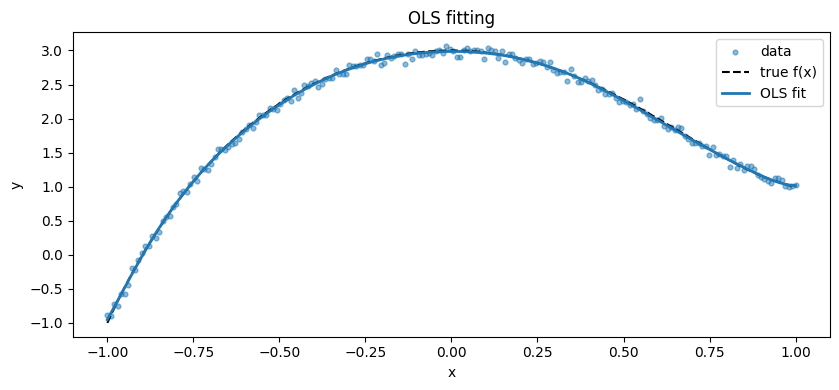

In [11]:
# OLS Results 
# Figure 1 - OLS fit curve 

plt.figure(figsize=(8.5, 4))
plt.scatter(x, y, s=12, alpha=0.5, label="data")
plt.plot(x, y_true, "k--", label="true f(x)")
plt.plot(x, y_hat, label="OLS fit", linewidth=2)
plt.xlabel("x"); plt.ylabel("y")
plt.title("OLS fitting")
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
# Ridge Regularization (L2)

# AIC, BIC optimised lambda 

lambdas = np.logspace(-6, 1, 30)
aic_list, bic_list = [], []

for lam in lambdas:
    w_r = np.linalg.solve(Theta.T@Theta + lam*np.eye(Theta.shape[1]), Theta.T@y)
    y_r = Theta @ w_r
    k = np.sum(np.abs(w_r) > 1e-8)          # number of active coefficients
    aic, bic = compute_aic_bic(y_true, y_r, k)
    aic_list.append(aic)
    bic_list.append(bic)

lam_aic = lambdas[np.argmin(aic_list)]
lam_bic = lambdas[np.argmin(bic_list)]

print("Opt_lam_aic: ", lam_aic)
print("Opt_lam_bic: ", lam_bic)

lambda_ridge = lam_aic        #Tuning parameter 

# Ridge Regression (From derived w_MAP)

I = np.eye(Theta.shape[1])
w_ridge = np.linalg.solve(Theta.T @ Theta + lambda_ridge * I, Theta.T @ y)
y_ridge = Theta @ w_ridge

print("Ridge polynomial: y(x) =", format_poly(w_ridge))


Opt_lam_aic:  0.007278953843983154
Opt_lam_bic:  0.007278953843983154
Ridge polynomial: y(x) = +2.9887 +0.0018782·x -2.955·x^2 +0.035625·x^3 -0.17787·x^4 +0.75223·x^5 +0.20662·x^6 +0.43457·x^7 +0.010883·x^8 -0.23054·x^9 -0.060387·x^10


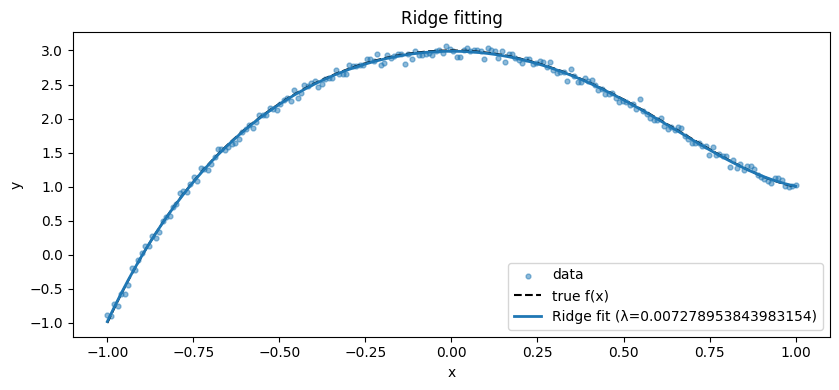

In [13]:
# Figure 2 - Ridge Regression Fit curve 

plt.figure(figsize=(8.5, 4))
plt.scatter(x, y, s=12, alpha=0.5, label="data")
plt.plot(x, y_true, "k--", label="true f(x)")
plt.plot(x, y_ridge, label=f"Ridge fit (λ={lambda_ridge})", linewidth=2)
plt.xlabel("x"); plt.ylabel("y")
plt.title("Ridge fitting")
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
# Lasso regularaisation (L1)

alpha_lasso = 1e-3   # larger alpha -> more sparse

# Lasso Fitting

lasso = Lasso(alpha=alpha_lasso, fit_intercept=False, max_iter=10000)
lasso.fit(Theta, y)
w_lasso = lasso.coef_
y_lasso = Theta @ w_lasso

print(f"Lasso polynomial (alpha={alpha_lasso}): y(x) = {format_poly(w_lasso)}")


Lasso polynomial (alpha=0.001): y(x) = +2.9829 -2.9714·x^2 +0.029686·x^3 +0.95107·x^5


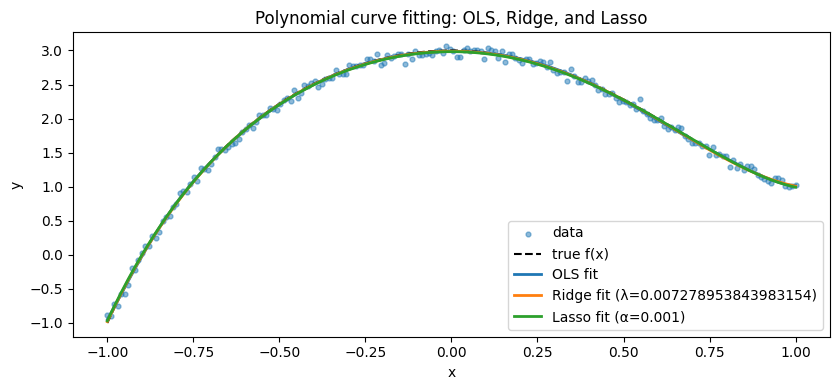

In [15]:
# Lasso Plot comparison

plt.figure(figsize=(8.5, 4))
plt.scatter(x, y, s=12, alpha=0.5, label="data")
plt.plot(x, y_true, "k--", label="true f(x)")
plt.plot(x, y_hat,   label="OLS fit", linewidth=2)
plt.plot(x, y_ridge, label=f"Ridge fit (λ={lambda_ridge})", linewidth=2)
plt.plot(x, y_lasso, label=f"Lasso fit (α={alpha_lasso})", linewidth=2)
plt.xlabel("x"); plt.ylabel("y")
plt.title("Polynomial curve fitting: OLS, Ridge, and Lasso")
plt.legend()
plt.tight_layout()
plt.show()


OLS   RMSE=1.1053e-02, MAE=8.8243e-03
Ridge RMSE=8.6458e-03, MAE=8.1864e-03
Lasso RMSE=1.2328e-02, MAE=1.0504e-02


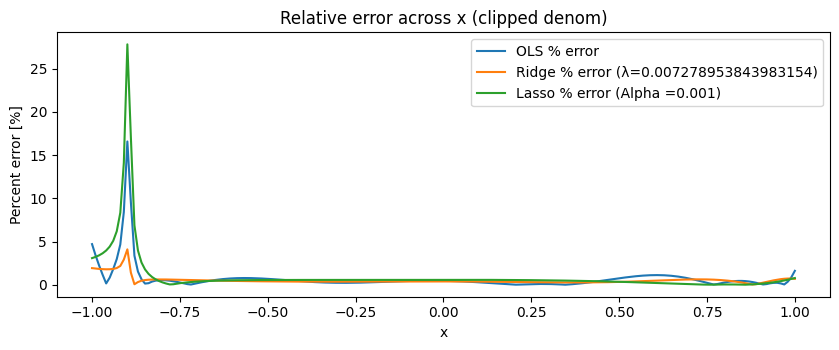

In [17]:
# Error comparison 

# RMSE, MAE comparison
def rmse(a, b): return np.sqrt(np.mean((a - b)**2))
def mae(a, b):  return np.mean(np.abs(a - b))

err_ols_rmse = rmse(y_hat, y_true)
err_ridge_rmse = rmse(y_ridge, y_true)
err_lasso_rmse = rmse(y_lasso, y_true)

err_ols_mae = mae(y_hat, y_true)
err_ridge_mae = mae(y_ridge, y_true)
err_lasso_mae = mae(y_lasso, y_true)

print(f"OLS   RMSE={err_ols_rmse:.4e}, MAE={err_ols_mae:.4e}")
print(f"Ridge RMSE={err_ridge_rmse:.4e}, MAE={err_ridge_mae:.4e}")
print(f"Lasso RMSE={rmse(y_lasso, y_true):.4e}, MAE={err_lasso_mae:.4e}")

# percentage error comparison plot
eps = 0.05 * np.std(y_true)
denom = np.clip(np.abs(y_true), eps, None)
err_ols_pct   = 100 * np.abs(y_hat   - y_true) / denom
err_ridge_pct = 100 * np.abs(y_ridge - y_true) / denom
err_lasso_pct = 100 * np.abs(y_lasso - y_true) / denom


plt.figure(figsize=(8.5, 3.6))
plt.plot(x, err_ols_pct,   label="OLS % error")
plt.plot(x, err_ridge_pct, label=f"Ridge % error (λ={lambda_ridge})")
plt.plot(x, err_lasso_pct, label=f"Lasso % error (Alpha ={alpha_lasso})")
plt.xlabel("x"); plt.ylabel("Percent error [%]")
plt.title("Relative error across x (clipped denom)")
plt.legend()
plt.tight_layout()
plt.show()
